In [107]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
full_df = pd.read_csv('anes_timeseries_2020_csv_20220210.csv')

full_df.head(1)

C:\Users\anita\AppData\Local\Temp\ipykernel_28124\1230752811.py:1: DtypeWarning: Columns (15,17,18,19,21,22,23,25,26,27,29,30,31,33,34,35,37,38,1508,1509) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df = pd.read_csv('anes_timeseries_2020_csv_20220210.csv')


,version,V200001,V160001_orig,V200002,V200003,V200004,V200005,V200006,V200007,V200008,...,V203518,V203519,V203520,V203521,V203522,V203523,V203524,V203525,V203526,V203527
0,ANES2020TimeSeries_20220210,200015,401318,3,2,3,0,-2,-2,-2,...,Thomas Jeffery 'Tom' Cole,1,-1. Inapplicable,-1,-1,82,-1. Inapplicable,-1,-1. Inapplicable,-1


In [1058]:
# Variables, in two senses of the word ;)

voted_for_pres = 'V202072' # 1 yes, 2 no
feminist = 'V202475' # 1 feminist, 2 antifeminist, 3 neither
covid_reopening = 'V201396x' # 1 too quickly, 5 too slowly

vote_pres_choice = 'V202073' # 0 Joe Biden, 1 Donald Trump

persp_race = 'V202453' # 1 consider extremely often, 5 not often at all
gov_healthcare_spending = 'V202380x' # 1 increase a lot, 7 decrease a lot
gov_covid_response = 'V201392x' # 1 too quick, 5 too slow
economy_state = 'V201324' # 1 very good, 5 very bad
police_thermometer = 'V202171' # 0 is frosty, 100 is hot
r_race = 'V201549x'
    # 0 White non-Hispanic
    # 1 Black non-Hispanic
r_gender = 'V201600' # 0 male, 1 female

In [1059]:
# Trimming off non-relevant variables
trimmed_df = full_df[[vote_pres_choice, gov_covid_response,
                      gov_healthcare_spending,
                      economy_state, persp_race,
                      r_race, r_gender]]

# Drop NA/other extraneous
dropna_df = trimmed_df.dropna()
df_clean = dropna_df[
                       (dropna_df[vote_pres_choice].isin(range(1, 3))) &
                       (dropna_df[gov_healthcare_spending].isin(range(1, 8)) ) &
                       (dropna_df[gov_covid_response].isin(range(1, 6))) &
                       #(dropna_df[covid_reopening].isin(range(1, 6))) &
                       (dropna_df[economy_state].isin(range(1, 6))) &
                       (dropna_df[persp_race].isin(range(1, 6))) &
                       (dropna_df[r_race].isin(range(1, 3))) &
                       (dropna_df[r_gender].isin(range(1, 3))) ]


# Recoding/Rescaling/Standardizing
df_clean[vote_pres_choice] = df_clean[vote_pres_choice] - 1
df_clean[r_gender] = df_clean[r_gender] - 1
df_clean[r_race] = df_clean[r_race] - 1

scaler = StandardScaler()
df_clean[[gov_healthcare_spending, gov_covid_response, economy_state, persp_race]] = scaler.fit_transform(
    df_clean[[gov_healthcare_spending, gov_covid_response, economy_state, persp_race]]
)

# Renaming everything LOL

df_clean.rename(columns={
    #voted_for_pres: 'voted_for_pres',
    vote_pres_choice: 'vote_pres_choice',
    gov_healthcare_spending: 'gov_healthcare_spending',
    gov_covid_response: 'gov_covid_response',
    #covid_reopening: 'covid_reopening',
    economy_state: 'economy_state',
    persp_race: 'persp_race',
    r_race: 'r_race',
    r_gender: 'r_gender'}, inplace=True)

print(df_clean.head(5))

    vote_pres_choice  gov_covid_response  gov_healthcare_spending  \
2                  0            0.861622                -1.257207   
5                  0            0.861622                -0.649891   
6                  1            0.861622                 0.564740   
11                 0            0.861622                 0.564740   
12                 1           -0.117930                 0.564740   

    economy_state  persp_race  r_race  r_gender  
2        0.714586   -1.544164       0         1  
5       -0.173537    0.471905       0         1  
6        0.714586    0.471905       0         1  
11      -0.173537    0.471905       0         0  
12       0.714586    1.479940       0         1  


C:\Users\anita\AppData\Local\Temp\ipykernel_28124\591604795.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[vote_pres_choice] = df_clean[vote_pres_choice] - 1
C:\Users\anita\AppData\Local\Temp\ipykernel_28124\591604795.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[r_gender] = df_clean[r_gender] - 1
C:\Users\anita\AppData\Local\Temp\ipykernel_28124\591604795.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

r_gender             0             1            All
r_race                                             
0         1954 (41.6%)  2309 (49.2%)   4263 (90.8%)
1           153 (3.3%)    277 (5.9%)     430 (9.2%)
All       2107 (44.9%)  2586 (55.1%)  4693 (100.0%)


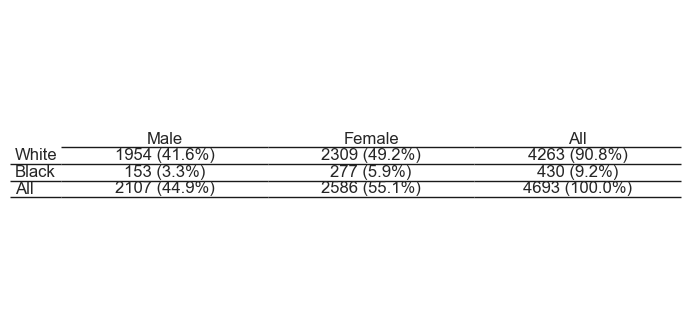

In [1195]:
from pandas.plotting import table

# Compute counts
counts = pd.crosstab(df_clean['r_race'], df_clean['r_gender'], margins=True)

# Compute percentages
percentages = pd.crosstab(df_clean['r_race'], df_clean['r_gender'], normalize='all', margins=True) * 100

# Combine counts and percentages into one DataFrame
combined_table = counts.astype(str) + " (" + percentages.round(1).astype(str) + "%)"
print(combined_table)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust size as needed
ax.axis('tight')
ax.axis('off')

# Render the table
table = ax.table(cellText=combined_table.values,
                 colLabels=['Male', 'Female', 'All'],
                 rowLabels=['White', 'Black', 'All'],
                 loc='center',
                 cellLoc='center',
                 edges='B')

# Save as an image file
plt.savefig("frequency_table.png", dpi=300, bbox_inches="tight")
plt.show()

r_gender                     0             1            All
vote_pres_choice                                           
0                 1089 (23.2%)  1498 (31.9%)   2587 (55.1%)
1                 1018 (21.7%)  1088 (23.2%)   2106 (44.9%)
All               2107 (44.9%)  2586 (55.1%)  4693 (100.0%)


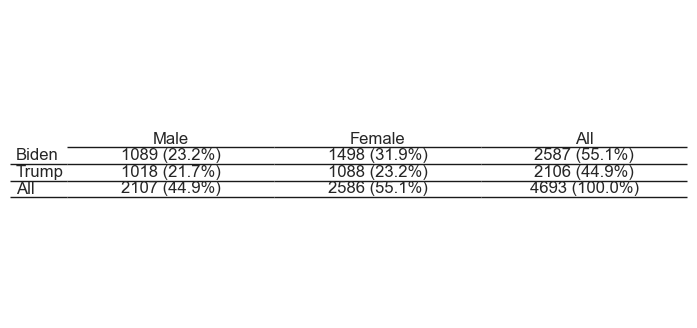

In [1196]:
counts = pd.crosstab(df_clean['vote_pres_choice'], df_clean['r_gender'], margins=True)

# Compute percentages
percentages = pd.crosstab(df_clean['vote_pres_choice'], df_clean['r_gender'], normalize='all', margins=True) * 100

# Combine counts and percentages into one DataFrame
combined_table = counts.astype(str) + " (" + percentages.round(1).astype(str) + "%)"
print(combined_table)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust size as needed
ax.axis('tight')
ax.axis('off')

# Render the table
table = ax.table(cellText=combined_table.values,
                 colLabels=['Male', 'Female', 'All'],
                 rowLabels=['Biden', 'Trump', 'All'],
                 loc='center',
                 cellLoc='center',
                 edges='B')

# Save as an image file
plt.savefig("frequency_table.png", dpi=300, bbox_inches="tight")
plt.show()

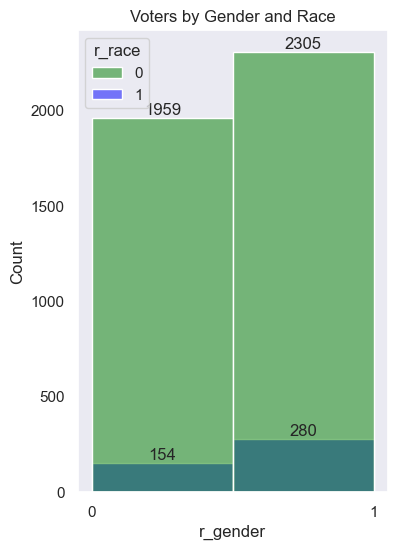

In [934]:
male_count = df_clean[df_clean['r_gender']==0]['vote_pres_choice'].count()
female_count = df_clean[df_clean['r_gender']==1]['vote_pres_choice'].count()

sns.set_theme(style='dark')

plt.figure(figsize=(4, 6))

gender_fig = sns.histplot(data=df_clean, 
                                   x='r_gender',
                                   hue='r_race',
                                   bins=2,
                                   #y='vote_pres_choice',
                                   #hue='r_gender',
                                   palette={0: 'green', 1:'blue'},)
                                   #errorbar=None)

gender_fig.set_xticks([0, 1])

gender_fig.set_title('Voters by Gender and Race')

for i in gender_fig.containers:
    gender_fig.bar_label(i,)

#plt.bar_label(female_count, male_count)

2585


Text(0.5, 0, 'Number of Voters')

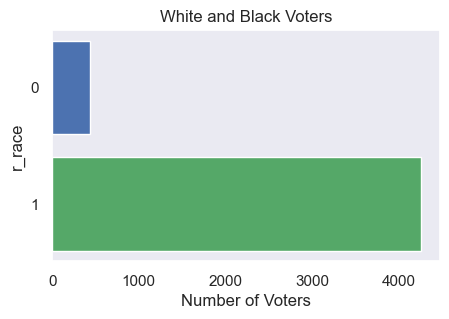

In [935]:
white_count = df_clean[df_clean['r_race']==0]['vote_pres_choice'].count()
black_count = df_clean[df_clean['r_race']==1]['vote_pres_choice'].count()

sns.set_theme(style='dark')

print(female_count)

plt.figure(figsize=(5, 3))

plt.barh('1', white_count, color='g')

plt.barh('0', black_count, color='b')

plt.title('White and Black Voters')
plt.ylabel('r_race')
plt.xlabel('Number of Voters')

In [1061]:
# descriptive stats and visualizations

matching_columns = ['gov_covid_response',
             'gov_healthcare_spending',
             'persp_race',
             'economy_state']


Text(0.5, 1.0, 'Government Was Too Slow to Respond to COVID')

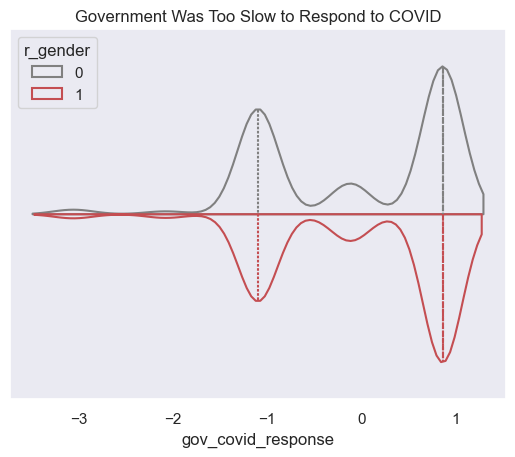

In [1060]:
sns.set_theme(style="dark")

df_clean_columns = df_clean[['gov_covid_response',
             'gov_healthcare_spending',
             'persp_race',
             'economy_state',
            'r_gender',
            'r_race']]

# Draw a nested violinplot and split the violins for easier comparison
gov_covid_response_fig = sns.violinplot(data=df_clean_columns, 
               x='gov_covid_response',
               hue="r_gender",
               split=True, inner="quart", fill=False,
               palette={1: "r", 0: "gray"}
               )

gov_covid_response_fig.set_title('Government Was Too Slow to Respond to COVID')

Text(0.5, 1.0, 'Government Was Too Slow to Respond to COVID')

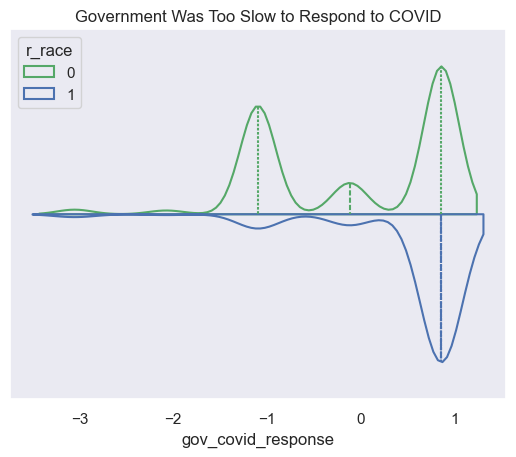

In [561]:
sns.set_theme(style="dark")

# Draw a nested violinplot and split the violins for easier comparison
gov_covid_response_fig = sns.violinplot(data=df_clean_columns, 
               x='gov_covid_response',
               hue="r_race",
               split=True, inner="quart", fill=False,
               palette={1: "b", 0: "g"}
               )

gov_covid_response_fig.set_title('Government Was Too Slow to Respond to COVID')

Text(0.5, 1.0, 'Government Should Decrease Healthcare Spending')

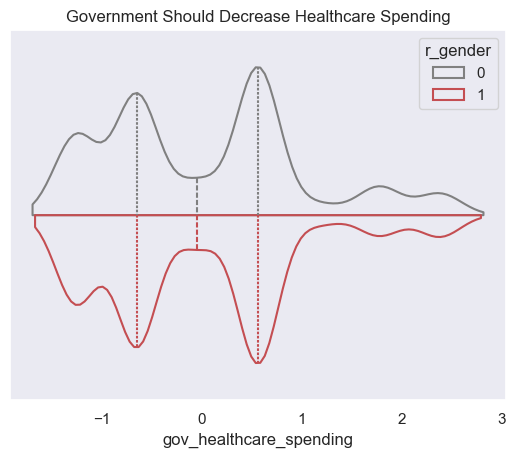

In [525]:
# Draw a nested violinplot and split the violins for easier comparison
gov_healthcare_spending_fig = sns.violinplot(data=df_clean_columns, x='gov_healthcare_spending', hue="r_gender",
               split=True, inner="quart", fill=False,
               palette={1: "r", 0: "gray"}
               )

gov_healthcare_spending_fig.set_title('Government Should Decrease Healthcare Spending')

Text(0.5, 1.0, 'Government Should Decrease Healthcare Spending')

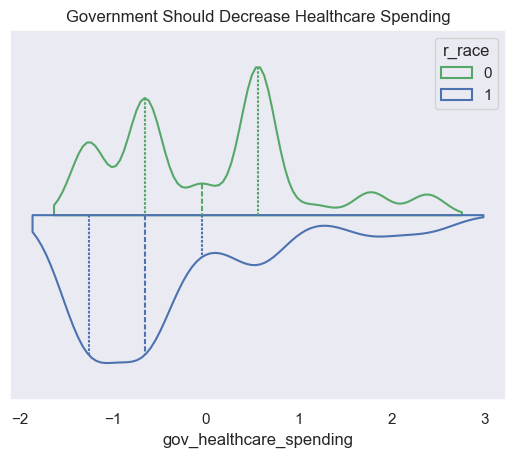

In [562]:
# Draw a nested violinplot and split the violins for easier comparison
gov_healthcare_spending_fig = sns.violinplot(data=df_clean_columns, x='gov_healthcare_spending', hue="r_race",
               split=True, inner="quart", fill=False,
               palette={1: "b", 0: "g"}
               )

gov_healthcare_spending_fig.set_title('Government Should Decrease Healthcare Spending')

Text(0.5, 1.0, 'Respondent Does not Consider Other Race Perspectives Very Often')

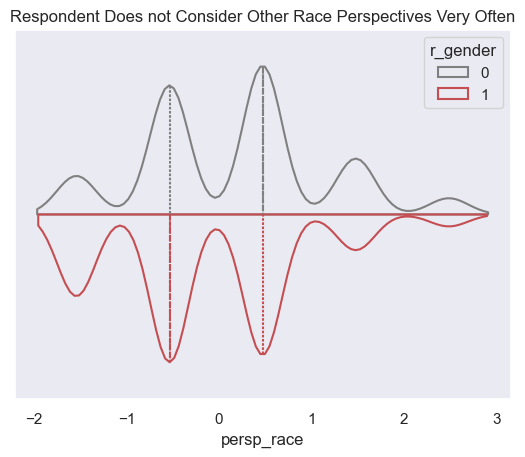

In [1062]:
# Draw a nested violinplot and split the violins for easier comparison
persp_race_fig = sns.violinplot(data=df_clean_columns, x='persp_race', hue="r_gender",
               split=True, inner="quart", fill=False,
               palette={1: "r", 0: "gray"}
               )

persp_race_fig.set_title('Respondent Does not Consider Other Race Perspectives Very Often')

Text(0.5, 1.0, 'Respondent Does not Consider Other Race Perspectives Very Often')

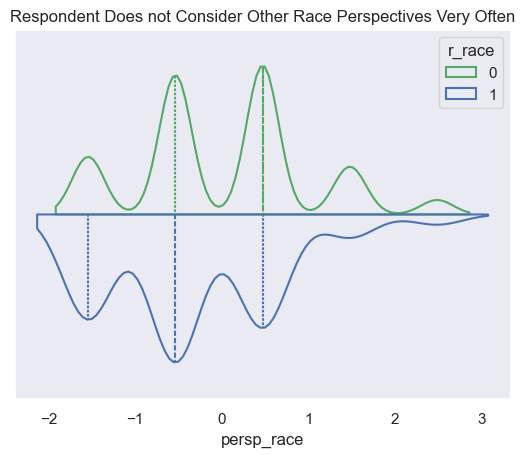

In [1064]:
# Draw a nested violinplot and split the violins for easier comparison
persp_race_fig = sns.violinplot(data=df_clean_columns, x='persp_race', hue="r_race",
               split=True, inner="quart", fill=False,
               palette={1: "b", 0: "g"}
               )

persp_race_fig.set_title('Respondent Does not Consider Other Race Perspectives Very Often')

Text(0.5, 1.0, 'Respondent Believes the Economy is Doing Well')

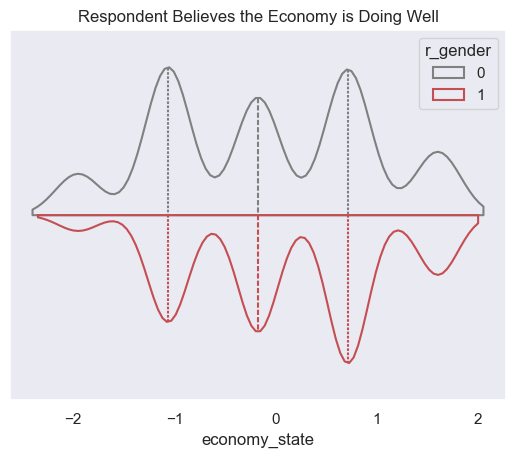

In [527]:
# Draw a nested violinplot and split the violins for easier comparison
economy_state_fig = sns.violinplot(data=df_clean_columns, x='economy_state', hue="r_gender",
               split=True, inner="quart", fill=False,
               palette={1: "r", 0: "gray"}
               )

economy_state_fig.set_title('Respondent Believes the Economy is Doing Well')

Text(0.5, 1.0, 'Respondent Believes the Economy is Doing Well')

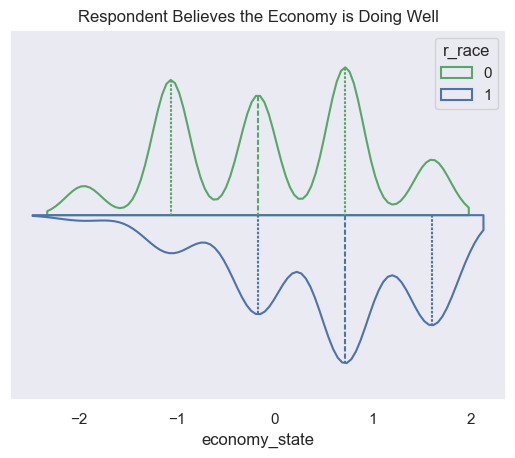

In [564]:
# Draw a nested violinplot and split the violins for easier comparison
economy_state_fig = sns.violinplot(data=df_clean_columns, x='economy_state', hue="r_race",
               split=True, inner="quart", fill=False,
               palette={1: "b", 0: "g"}
               )

economy_state_fig.set_title('Respondent Believes the Economy is Doing Well')

Text(0.5, 1.0, 'Percentage Voted for Trump')

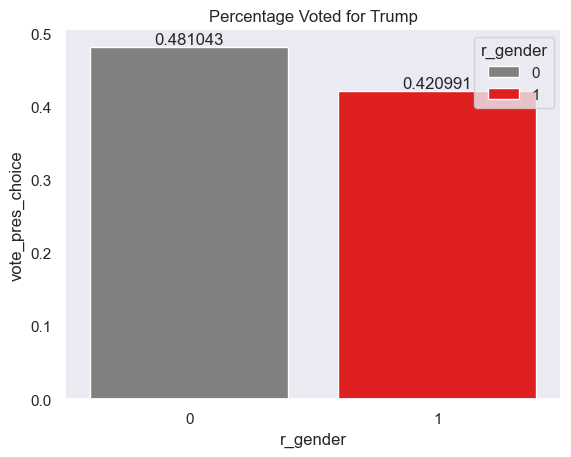

In [528]:
vote_pres_choice_fig = sns.barplot(data=df_clean, 
                                   x='r_gender',
                                   y='vote_pres_choice',
                                   hue='r_gender',
                                   palette={0: 'gray', 1:'red'},
                                   errorbar=None)

for i in vote_pres_choice_fig.containers:
    vote_pres_choice_fig.bar_label(i,)

vote_pres_choice_fig.set_title('Percentage Voted for Trump')

Text(0.5, 1.0, 'Percentage Voted for Trump')

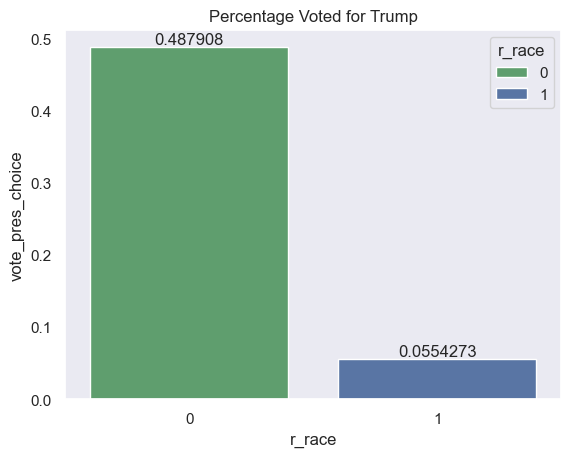

In [530]:
vote_pres_choice_fig = sns.barplot(data=df_clean, 
                                   x='r_race',
                                   y='vote_pres_choice',
                                   hue='r_race',
                                   palette={0: 'g', 1:'b'},
                                   errorbar=None)

for i in vote_pres_choice_fig.containers:
    vote_pres_choice_fig.bar_label(i,)

vote_pres_choice_fig.set_title('Percentage Voted for Trump')

In [1078]:
# Split data into treatment (female) and control (male) groups for NN matching
df_female = df_clean[df_clean['r_gender'] == 1]  # Treatment group
df_male = df_clean[df_clean['r_gender'] == 0]    # Control group

# Select matching variables
X_female = df_female[matching_columns].values  # Treatment group features
X_male = df_male[matching_columns].values      # Control group features

In [1170]:
# Allow more neighbors for better coverage
nn = NearestNeighbors(n_neighbors=50, metric='euclidean')  # Try 3 nearest neighbors
nn.fit(X_male)
distances, indices = nn.kneighbors(X_female)

# Use only the closest neighbor for matching without replacement
final_indices = []
final_distances = []
used_control_indices = set()

# check order for distances
# print(distances[:10])

for i, idx_list in enumerate(indices):
    for idx in idx_list:  # Iterate over neighbors
        if idx not in used_control_indices:
            final_indices.append(idx)
            # Use NumPy to find the position of `idx` in `idx_list`
            position = np.where(idx_list == idx)[0][0]  # Get the first match
            final_distances.append(distances[i, position])
            used_control_indices.add(idx)
            break
    else:
        final_indices.append(None)  # Mark as unmatched
        final_distances.append(np.inf)  # Assign infinite distance for unmatched

# Create matched data
df_female['matched_control_index'] = final_indices
df_female['distance'] = final_distances
df_female_matched = df_female.dropna(subset=['matched_control_index'])  # Remove unmatched treatment

# Filter matched controls and assign distances
matched_male = df_male.iloc[df_female_matched['matched_control_index'].astype(int)].copy()
matched_male['distance'] = df_female_matched['distance'].values

# Combine the matched treatment and control groups
matched_pairs_euclidean = pd.concat([df_female_matched, matched_male], axis=0)

# Exponential decay weighting
tau = 0.1
matched_pairs_euclidean['weights'] = np.exp(-matched_pairs_euclidean['distance'] / tau)


# Assign weights as inverse of the distance
#matched_pairs_euclidean['weights'] = np.where(
 #   matched_pairs_euclidean['distance'] == np.inf,
  #  0,  # Assign weight of 0 for unmatched
   # 1 / (matched_pairs_euclidean['distance'] + 0.1)  # Calculate weights for matched
#)

# Output diagnostics
print("Matched pairs preview:")
print(matched_pairs_euclidean[['r_gender', 'distance', 'weights']].head(5))

# Check the number of unmatched treatment observations
unmatched_count = df_female.shape[0] - df_female_matched.shape[0]
print(f"Number of unmatched treatment observations: {unmatched_count}")

print(len(matched_pairs_euclidean))

print((matched_pairs_euclidean['weights']==0).sum())


Matched pairs preview:
    r_gender  distance  weights
2          1       0.0      1.0
5          1       0.0      1.0
6          1       0.0      1.0
12         1       0.0      1.0
18         1       0.0      1.0
Number of unmatched treatment observations: 735
3702
0


C:\Users\anita\AppData\Local\Temp\ipykernel_28124\4283784257.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_female['matched_control_index'] = final_indices
C:\Users\anita\AppData\Local\Temp\ipykernel_28124\4283784257.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_female['distance'] = final_distances


In [1171]:
matched_pairs_euclidean['distance'].describe()

count    3702.000000
mean        0.225302
std         0.410353
min         0.000000
25%         0.000000
50%         0.000000
75%         0.607316
max         2.203230
Name: distance, dtype: float64

In [1172]:
def compute_smd(df, treatment_col, covariates, pre_post='Pre-Matching', weights=None):
    smd_results = []
    for cov in covariates:
        # Compute means and variances for treatment and control groups
        treat = df[df[treatment_col] == 1]
        control = df[df[treatment_col] == 0]
        
        if weights:
            # Weighted means and variances
            mean_treat = np.average(treat[cov], weights=treat[weights])
            mean_control = np.average(control[cov], weights=control[weights])
            var_treat = np.average((treat[cov] - mean_treat)**2, weights=treat[weights])
            var_control = np.average((control[cov] - mean_control)**2, weights=control[weights])
        else:
            # Unweighted means and variances
            mean_treat = treat[cov].mean()
            mean_control = control[cov].mean()
            var_treat = treat[cov].var()
            var_control = control[cov].var()
        
        # Compute SMD
        smd = (mean_treat - mean_control) / np.sqrt((var_treat + var_control) / 2)
        smd_results.append({'Covariate': cov, 'SMD': smd, 'pre_post': pre_post})
    
    return pd.DataFrame(smd_results)


In [1200]:
# Pre-matching SMDs
pre_nn_smd = compute_smd(df_clean, treatment_col='r_gender', covariates=matching_columns+['vote_pres_choice'], pre_post='Pre-Matching SMD')

# Post-matching SMDs (e.g., for Nearest Neighbor Matching)
post_nn_smd = compute_smd(matched_pairs_euclidean, treatment_col='r_gender', covariates=matching_columns+['vote_pres_choice'], pre_post='Post-Matching SMD', weights='weights'
                          )

df_to_be = []

print(pre_nn_smd)
print(post_nn_smd)

                 Covariate       SMD          pre_post
0       gov_covid_response  0.073988  Pre-Matching SMD
1  gov_healthcare_spending -0.073349  Pre-Matching SMD
2               persp_race -0.305197  Pre-Matching SMD
3            economy_state  0.182531  Pre-Matching SMD
4         vote_pres_choice -0.125650  Pre-Matching SMD
                 Covariate           SMD           pre_post
0       gov_covid_response -5.339247e-07  Post-Matching SMD
1  gov_healthcare_spending  6.747432e-05  Post-Matching SMD
2               persp_race -1.167883e-06  Post-Matching SMD
3            economy_state  4.495862e-06  Post-Matching SMD
4         vote_pres_choice  4.428433e-03  Post-Matching SMD


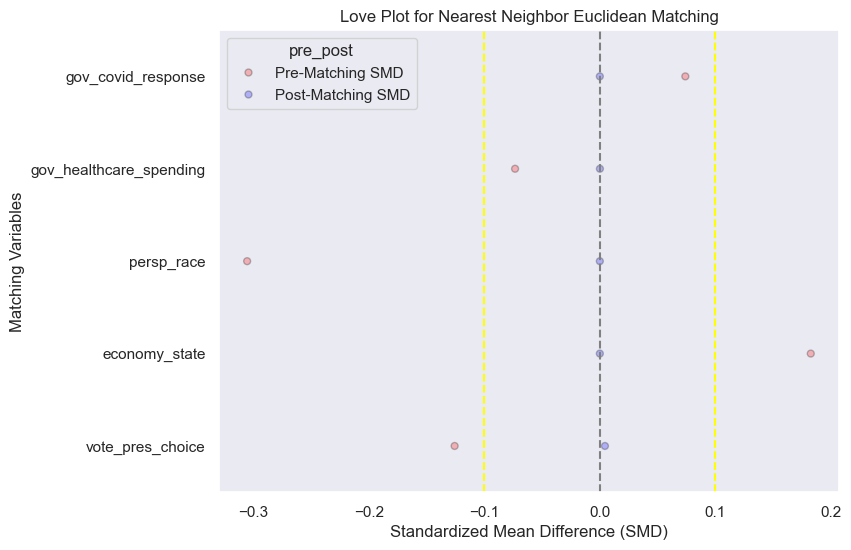

In [1201]:
def plot_love_plot(pre_smd, post_smd, match_type=None):

    plt.figure(figsize=(8, 6))

    df_smd = pd.concat([pre_smd, post_smd])
    
    # Post-matching SMD
    figure = sns.swarmplot(
    data=df_smd, x="SMD", y="Covariate", hue='pre_post',
    palette={'Pre-Matching SMD': 'red', 'Post-Matching SMD': 'blue'},
    edgecolor='black',
    linewidth=1,
    alpha=.25,
    zorder=1, 
)
    
    # Reference line for SMD = 0.1
    plt.axvline(0.1, color='yellow', linestyle='--', label='Threshold (SMD=0.1)')
    plt.axvline(-0.1, color='yellow', linestyle='--')
    plt.axvline(0.0, color='gray', linestyle='--')
    
    # Labels and legend
    plt.xlabel('Standardized Mean Difference (SMD)')
    plt.ylabel('Matching Variables')
    plt.title('Love Plot')
    if match_type:
        plt.title(f'Love Plot for {match_type} Matching')
    #plt.legend()
    plt.show()

# Plot Love Plot
plot_love_plot(pre_nn_smd, post_nn_smd, 'Nearest Neighbor Euclidean')


r_gender             0             1            All
r_race                                             
0         1711 (46.2%)  1647 (44.5%)   3358 (90.7%)
1           140 (3.8%)    204 (5.5%)     344 (9.3%)
All       1851 (50.0%)  1851 (50.0%)  3702 (100.0%)


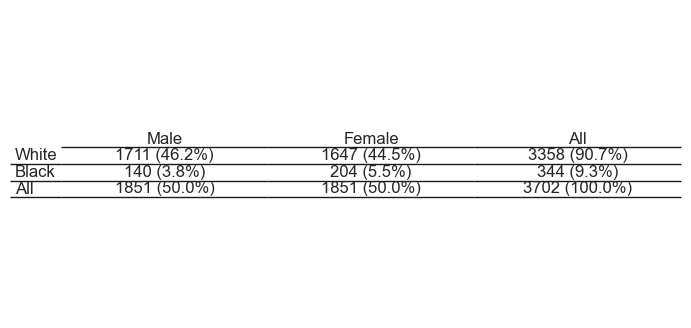

In [1208]:
# Compute counts
counts = pd.crosstab(matched_pairs_euclidean['r_race'], matched_pairs_euclidean['r_gender'], margins=True)

# Compute percentages
percentages = pd.crosstab(matched_pairs_euclidean['r_race'], matched_pairs_euclidean['r_gender'], normalize='all', margins=True) * 100

# Combine counts and percentages into one DataFrame
combined_table = counts.astype(str) + " (" + percentages.round(1).astype(str) + "%)"
print(combined_table)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust size as needed
ax.axis('tight')
ax.axis('off')

# Render the table
table = ax.table(cellText=combined_table.values,
                 colLabels=['Male', 'Female', 'All'],
                 rowLabels=['White', 'Black', 'All'],
                 loc='center',
                 cellLoc='center',
                 edges='B')

# Save as an image file
plt.savefig("frequency_table.png", dpi=300, bbox_inches="tight")
plt.show()

In [1205]:
(matched_pairs_euclidean['r_race']==1).sum()

344

In [1175]:
# Nearest Neighbor (Euclidean) Matched Logistic Regression

matched_pairs_euclidean['interaction'] = matched_pairs_euclidean['r_race'] * matched_pairs_euclidean['r_gender']

# Define the predictor (treatment) and the response (vote_pres_choice)
X = matched_pairs_euclidean[['r_gender', 'r_race', 'interaction']]  # Independent variable: treatment
X = sm.add_constant(X)  # Add an intercept term (constant) to the model
y = matched_pairs_euclidean['vote_pres_choice']  # Dependent variable: vote_pres_choice
weights = matched_pairs_euclidean['weights']  # Weights from matching

# Fit the logistic regression model
nn_model = smf.glm(
    formula='vote_pres_choice ~ r_gender + r_race + interaction',
    data = matched_pairs_euclidean,
    family=sm.families.Binomial(),
    freq_weights=np.asarray(weights) 
).fit()

# Print the summary of the logistic regression results
print(nn_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       vote_pres_choice   No. Observations:                 3702
Model:                            GLM   Df Residuals:                  2746.95
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1771.1
Date:                Sat, 07 Dec 2024   Deviance:                       3542.2
Time:                        19:01:39   Pearson chi2:                 2.75e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.05344
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.1958      0.056     -3.474      

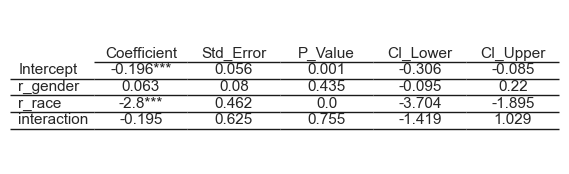

In [1197]:
from pandas.plotting import table

nn_summary = pd.DataFrame({
    #'Variable': nn_model.params.values,                # Variable names
    'Coefficient': nn_model.params,            # Coefficients
    'Std_Error': nn_model.bse.values,                 # Standard errors
    'P_Value': nn_model.pvalues.values,               # P-values
    'CI_Lower': nn_model.conf_int()[0].values,        # Lower bound of confidence intervals
    'CI_Upper': nn_model.conf_int()[1].values         # Upper bound of confidence intervals
})

nn_summary = nn_summary.round(3)

# Function to add asterisks based on significance levels
def add_significance(row):
    if row['P_Value'] <= 0.001:
        return '***'
    elif row['P_Value'] <= 0.01:
        return '**'
    elif row['P_Value'] <= 0.05:
        return '*'
    else:
        return ''

# Add a column for asterisks
nn_summary['Significance'] = nn_summary.apply(add_significance, axis=1)

# Combine coefficient and significance into a single column
nn_summary['Coefficient'] = nn_summary['Coefficient'].astype(str) + nn_summary['Significance']

nn_summary = nn_summary[[#'Variable', 
             'Coefficient',
             'Std_Error',
             'P_Value',
             'CI_Lower',
             'CI_Upper']]

# Plot the table
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust size as needed
ax.axis("off")
tbl = table(ax, nn_summary, loc="center", cellLoc="center", edges='B')

# Save the table as an image
plt.savefig("nn_summary.png", dpi=300, bbox_inches="tight")
plt.show()


In [1084]:
matched_pairs_euclidean['predicted_prob'] = nn_model.predict(sm.add_constant(matched_pairs_euclidean[['r_gender', 'r_race', 'interaction']]))
matched_pairs_euclidean['predicted_class'] = (matched_pairs_euclidean['predicted_prob'] > 0.5).astype(int)


print(matched_pairs_euclidean.head(5))


    vote_pres_choice  gov_covid_response  gov_healthcare_spending  \
2                  0            0.861622                -1.257207   
5                  0            0.861622                -0.649891   
6                  1            0.861622                 0.564740   
12                 1           -0.117930                 0.564740   
18                 0            0.861622                -0.649891   

    economy_state  persp_race  r_race  r_gender  matched_control_index  \
2        0.714586   -1.544164       0         1                  117.0   
5       -0.173537    0.471905       0         1                  669.0   
6        0.714586    0.471905       0         1                  987.0   
12       0.714586    1.479940       0         1                 1354.0   
18       0.714586    0.471905       0         1                   34.0   

    distance  weights  interaction  predicted_prob  predicted_class  
2        0.0      1.0            0        0.528307                1  


In [1056]:
from sklearn.metrics import classification_report

y_true = matched_pairs_euclidean['vote_pres_choice']
y_pred = matched_pairs_euclidean['predicted_class']

print(classification_report(y_true, y_pred, zero_division=np.nan))

              precision    recall  f1-score   support

           0       0.58      1.00      0.73      1732
           1        nan      0.00      0.00      1272

    accuracy                           0.58      3004
   macro avg       0.58      0.50      0.37      3004
weighted avg       0.58      0.58      0.42      3004



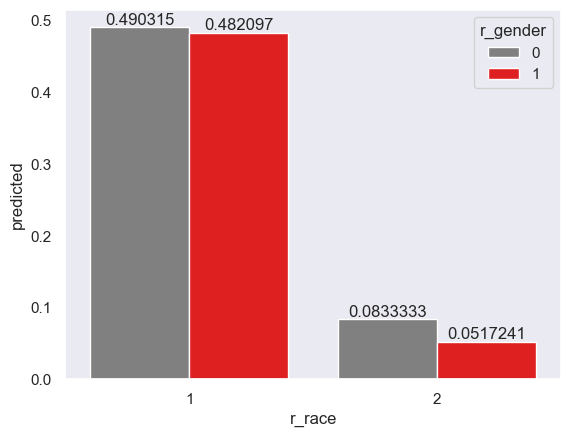

In [758]:
# Create predicted probabilities for each combination of r_gender and r_race
matched_pairs_euclidean['predicted'] = nn_model.predict(X)

# Plot the predicted probabilities
nn_euclidean_pred = sns.barplot(data=matched_pairs_euclidean, x='r_race', y='predicted', 
            hue='r_gender',
            palette={0: 'gray', 1: 'red'})

for i in nn_euclidean_pred.containers:
    nn_euclidean_pred.bar_label(i,)

In [1066]:
from cem import coarsen

df_coarsened = coarsen.coarsen(
    data=df_clean,
    treatment='r_gender',
    measure='l1',
    lower=4,
    upper=6,
    columns=matching_columns

)

0.2823918430481241


In [1067]:
from cem import match

df_matcher = df_coarsened[['r_gender',
                             'gov_covid_response',
                             'gov_healthcare_spending',
                             'persp_race',
                             'economy_state']]

weights = match.match(data=df_matcher, treatment='r_gender')

df_matcher['weights'] = weights

df_matcher.head(5)

c:\Users\anita\anaconda3\Lib\site-packages\cem\match.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  matched = data.groupby(gb).filter(lambda x: x[treatment].nunique() == data[treatment].nunique())
c:\Users\anita\anaconda3\Lib\site-packages\cem\match.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weights = pd.concat([_weight_stratum(stratum[treatment], global_level_counts) for _, stratum in matched.groupby(gb)])
C:\Users\anita\AppData\Local\Temp\ipykernel_28124\2605645592.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

,r_gender,gov_covid_response,gov_healthcare_spending,persp_race,economy_state,weights
2,1,"(0.078, 0.862]","(-1.261, -0.528]","(-1.548, -0.738]","(0.182, 0.892]",1.000000
5,1,"(0.078, 0.862]","(-1.261, -0.528]","(0.0687, 0.875]","(-0.529, 0.182]",1.000000
6,1,"(0.078, 0.862]","(0.2, 0.929]","(0.0687, 0.875]","(0.182, 0.892]",1.000000
11,0,"(0.078, 0.862]","(0.2, 0.929]","(0.0687, 0.875]","(-0.529, 0.182]",0.988525
12,1,"(-0.706, 0.078]","(0.2, 0.929]","(0.875, 1.682]","(0.182, 0.892]",1.000000


In [1068]:
df_coarsened['weights'] = df_matcher['weights'].values

df_coarsened.head(4)
    

,vote_pres_choice,gov_covid_response,gov_healthcare_spending,economy_state,persp_race,r_race,r_gender,weights
2,0,"(0.078, 0.862]","(-1.261, -0.528]","(0.182, 0.892]","(-1.548, -0.738]",0,1,1.000000
5,0,"(0.078, 0.862]","(-1.261, -0.528]","(-0.529, 0.182]","(0.0687, 0.875]",0,1,1.000000
6,1,"(0.078, 0.862]","(0.2, 0.929]","(0.182, 0.892]","(0.0687, 0.875]",0,1,1.000000
11,0,"(0.078, 0.862]","(0.2, 0.929]","(-0.529, 0.182]","(0.0687, 0.875]",0,0,0.988525


In [1069]:
def replace_dummies(column):
    df_coarsened[column] = pd.factorize(df_coarsened[column])[0]
    
for column in matching_columns:
    replace_dummies(column)

In [1070]:
for column in matching_columns:
    values = df_coarsened[column].value_counts()
    print(f'number of bins for {column}: {len(values)}')
    print(f'max number in bins: {values.max()}')
    print(f'min number in bins: {values.min()}')

number of bins for gov_covid_response: 5
max number in bins: 2490
min number in bins: 56
number of bins for gov_healthcare_spending: 5
max number in bins: 2215
min number in bins: 101
number of bins for persp_race: 5
max number in bins: 1677
min number in bins: 162
number of bins for economy_state: 5
max number in bins: 1448
min number in bins: 260


In [1202]:
pre_coarsened_smd = compute_smd(df_clean, treatment_col='r_gender', covariates=matching_columns+['vote_pres_choice'], pre_post='Pre-Matching SMD')

# Post-matching SMDs (e.g., for Nearest Neighbor Matching)
post_coarsened_smd = compute_smd(df_coarsened, treatment_col='r_gender', covariates=matching_columns+['vote_pres_choice'], pre_post='Post-Matching SMD', weights='weights')

print(pre_coarsened_smd)
print(post_coarsened_smd)

                 Covariate       SMD          pre_post
0       gov_covid_response  0.073988  Pre-Matching SMD
1  gov_healthcare_spending -0.073349  Pre-Matching SMD
2               persp_race -0.305197  Pre-Matching SMD
3            economy_state  0.182531  Pre-Matching SMD
4         vote_pres_choice -0.125650  Pre-Matching SMD
                 Covariate           SMD           pre_post
0       gov_covid_response -1.159469e-16  Post-Matching SMD
1  gov_healthcare_spending  1.133559e-16  Post-Matching SMD
2               persp_race  0.000000e+00  Post-Matching SMD
3            economy_state  0.000000e+00  Post-Matching SMD
4         vote_pres_choice  1.025069e-02  Post-Matching SMD


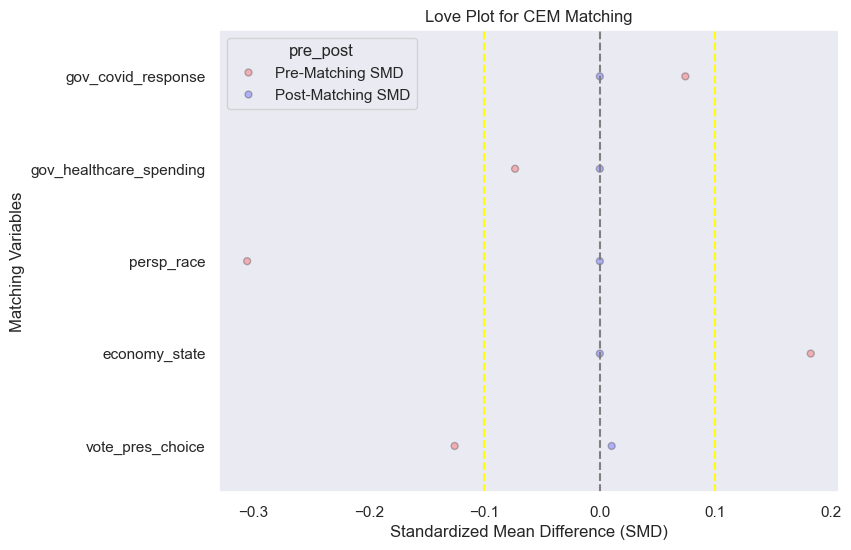

In [1203]:
plot_love_plot(pre_coarsened_smd, post_coarsened_smd, match_type='CEM')

In [1199]:
print(df_coarsened[df_coarsened['weights'] != 0 ].shape[0], "observations with zero weight.")

s = df_clean['r_gender'].value_counts()
s
s[1] - s[0]

print(df_coarsened[['r_race', 'vote_pres_choice']].groupby('r_race').mean())


4450 observations with zero weight.
        vote_pres_choice
r_race                  
0               0.488623
1               0.053488


In [1088]:
# Define the predictors and response
df_coarsened['interaction'] = df_coarsened['r_gender'] * df_coarsened['r_race']  # Create interaction term
X = df_coarsened[['r_gender','r_race', 'interaction']]  # Predictors
X = sm.add_constant(X)  # Add intercept term
y = df_coarsened['vote_pres_choice']  # Response variable

# Get weights
weights = df_coarsened['weights']

# Perform weighted logistic regression using GLM
cem_model = smf.glm(
    formula='vote_pres_choice ~ r_gender + r_race + interaction',
    data = df_coarsened,
    family=sm.families.Binomial(),
    freq_weights=np.asarray(weights) 
).fit()

# Print the summary of the results
print(cem_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:       vote_pres_choice   No. Observations:                 4693
Model:                            GLM   Df Residuals:                     4446
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2846.0
Date:                Thu, 05 Dec 2024   Deviance:                       5692.1
Time:                        17:27:57   Pearson chi2:                 4.45e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.06643
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.2472      0.047     -5.250      

In [1085]:
df_coarsened['predicted_prob'] = cem_model.predict(sm.add_constant(df_coarsened[['r_gender', 'r_race', 'interaction']]))
df_coarsened['predicted_class'] = (df_coarsened['predicted_prob'] > 0.5).astype(int)


print(df_coarsened.head(5))


    vote_pres_choice  gov_covid_response  gov_healthcare_spending  \
2                  0                   0                        0   
5                  0                   0                        0   
6                  1                   0                        1   
11                 0                   0                        1   
12                 1                   1                        1   

    economy_state  persp_race  r_race  r_gender   weights  interaction  \
2               0           0       0         1  1.000000            0   
5               1           1       0         1  1.000000            0   
6               0           1       0         1  1.000000            0   
11              1           1       0         0  0.988525            0   
12              0           2       0         1  1.000000            0   

    predicted_prob  predicted_class  
2         0.451510                0  
5         0.451510                0  
6         0.451510        

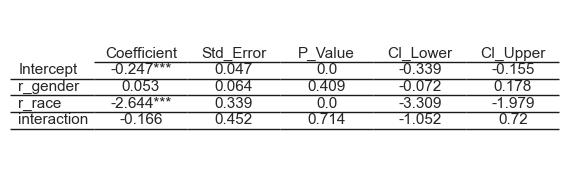

In [1198]:
cem_summary = pd.DataFrame({
    #'Variable': nn_model.params.values,                # Variable names
    'Coefficient': cem_model.params,            # Coefficients
    'Std_Error': cem_model.bse.values,                 # Standard errors
    'P_Value': cem_model.pvalues.values,               # P-values
    'CI_Lower': cem_model.conf_int()[0].values,        # Lower bound of confidence intervals
    'CI_Upper': cem_model.conf_int()[1].values         # Upper bound of confidence intervals
})

cem_summary = cem_summary.round(3)

# Function to add asterisks based on significance levels
def add_significance(row):
    if row['P_Value'] <= 0.001:
        return '***'
    elif row['P_Value'] <= 0.01:
        return '**'
    elif row['P_Value'] <= 0.05:
        return '*'
    else:
        return ''

# Add a column for asterisks
cem_summary['Significance'] = cem_summary.apply(add_significance, axis=1)

# Combine coefficient and significance into a single column
cem_summary['Coefficient'] = cem_summary['Coefficient'].astype(str) + cem_summary['Significance']
cem_summary = cem_summary[[#'Variable', 
             'Coefficient',
             'Std_Error',
             'P_Value',
             'CI_Lower',
             'CI_Upper']]

# Plot the table
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust size as needed
ax.axis("off")
tbl = table(ax, cem_summary, loc="center", cellLoc="center", edges='B')

# Save the table as an image
plt.savefig("cem_summary.png", dpi=300, bbox_inches="tight")
plt.show()

In [1057]:
y_true = df_coarsened['vote_pres_choice']
y_pred = df_coarsened['predicted_class']

print(classification_report(y_true, y_pred, zero_division=np.nan))

Accuracy: 0.552
Precision: 0.000
Recall: 0.000
ROC-AUC: 0.593
              precision    recall  f1-score   support

           0       0.55      1.00      0.71      2593
           1        nan      0.00      0.00      2105

    accuracy                           0.55      4698
   macro avg       0.55      0.50      0.36      4698
weighted avg       0.55      0.55      0.39      4698



c:\Users\anita\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


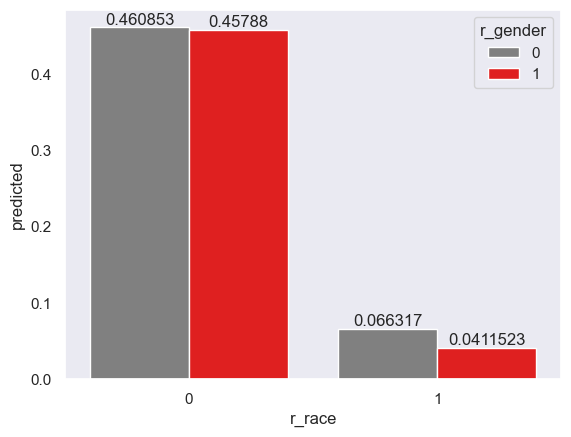

In [986]:
# Create predicted probabilities for each combination of r_gender and r_race
df_coarsened['predicted'] = cem_model.predict(X)

# Plot the predicted probabilities
coarsened_pred = sns.barplot(data=df_coarsened, x='r_race', y='predicted', 
            hue='r_gender',
            palette={0: 'gray', 1: 'red'})

for i in coarsened_pred.containers:
    coarsened_pred.bar_label(i,)

In [1207]:
df_clean['interaction'] = df_clean['r_gender'] * df_clean['r_race']  # Create interaction term
X = df_clean[['r_gender','r_race', 'interaction']]  # Predictors
X = sm.add_constant(X)  # Add intercept term
y = df_clean['vote_pres_choice']  # Response variable

# Get weights
# weights = df_coarse['weights']

# Perform weighted logistic regression using GLM
clean_model = smf.glm(
    formula='vote_pres_choice ~ r_gender + r_race + interaction + persp_race + economy_state + gov_healthcare_spending + gov_covid_response',
    data = df_clean,
    family=sm.families.Binomial(),
    #freq_weights=np.asarray(weights) 
).fit()

# Print the summary of the results
print(clean_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       vote_pres_choice   No. Observations:                 4693
Model:                            GLM   Df Residuals:                     4685
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1245.3
Date:                Sat, 07 Dec 2024   Deviance:                       2490.7
Time:                        23:45:34   Pearson chi2:                 1.05e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5705
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

C:\Users\anita\AppData\Local\Temp\ipykernel_28124\78210500.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['interaction'] = df_clean['r_gender'] * df_clean['r_race']  # Create interaction term
